In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results
from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model_asbest = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
model_asbest.load_state_dict(torch.load('asbest_segmentation_b3_v1.3.pth'))
model_asbest.eval();

In [2]:
def calculate_info(img_pathes, model):
    results = []
    for obj in img_pathes:
        img = cv2.imread(obj, cv2.IMREAD_UNCHANGED)
        img, st, asb = big_image_predict(model, 
                                         img,
                                         crop_size=(1024, 1024),
                                         inp_size=(1024, 1024),
                                         device=device
                                        )
        results.append(100*len(np.where(asb > 0.5)[0]) / img.shape[0] / img.shape[1])
    return results

In [3]:
dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2) 

def pz_approx(a, h, kernel, nums):
    t = np.linspace(min(a), max(a), nums)
    f = np.zeros(t.shape)
    for i in range(len(t)):
        for j in range(len(a)):
            f[i] += 1 / (len(a) * h) * np.sum(kernel((t[i] - a[j]) / h))
    return f

def get_quartiles(x, a):
    y = np.cumsum(a) / np.sum(a)
    indexes = np.argsort(abs(y - 0.05))[:2]
    q5 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.5))[:2]
    q50 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.95))[:2]
    q95 = x[indexes][0]
    return q5, q50, q95

def get_h(dist, h=0.01):
    direction = 1e-4
    a = np.array(dist)
    f = -np.Inf
    flag = True
    while abs(direction) >= 1e-5: 
        l = []
        h += direction
        if h <= 0:
            print('!')
            break 
        for i in range(len(a)):
            l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
        r = np.sum(l) / len(a)              
        if r < f:
            h -= direction
            if flag:
                direction = -direction
                flag = False
            else:
                direction = direction * 1e-1
        else:
            f = r
    return h

def plot_dist_pz(dist, h, num_points = 200):
    a = np.array(dist)
    hist, x, *_ = np.histogram(a, bins=10);
    hist = hist / sum(hist) / (x[1] - x[0])
    plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
    t = np.linspace(np.min(a), np.max(a), num_points)
    f = pz_approx(a, h, dist_norm, num_points)
    q5, q50, q95 = get_quartiles(t, f)
    plt.plot(t, f, 'r')
    plt.xlabel('Удельное содержание асбеста')
    plt.vlines(np.array([q5, q50, q95]), 0, max(hist))
    print('Квантиль на уровне доверительной вероятности 0.05 = ', q5)
    print('Квантиль на уровне доверительной вероятности 0.50 = ', q50)
    print('Квантиль на уровне доверительной вероятности 0.95 = ', q95)
    return q5, q50, q95

In [4]:
path = 'asbestos/stones/020221/'

data = {
    '02-02-21' : 
    { 1 : 
     { 'content' : 0.030,
         'images' : [
        'asbestos/stones/020221/ManualDetailedImage_12_04_45f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_05_01_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_06_30f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_07_14_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_08_07f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_08_29_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_09_38f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_09_52_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_11_17f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_11_32_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_13_48f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_14_01_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_15_13f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_15_45_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_17_26f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_17_46_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_19_00f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_19_17_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_23_52f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_24_11_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_25_15f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_25_24_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_27_03f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_27_48_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_31_20f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_32_00_300.bmp'],
     },
     2 : 
     { 'content' : 0.015,
         'images' :[
         'asbestos/stones/020221/ManualDetailedImage_12_47_38f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_49_13_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_51_54f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_52_28_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_55_14f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_55_48_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_58_06f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_58_51_150.bmp'
     ]
     }
    },
    '16-12-20': 
     { 2: 
      { 'content' : 0.02,
         'images' :
      [
         'asbestos/stones/161220/ManualDetailedImage_10_01_52.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_03_00.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_03_35.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_05_20.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_05_58.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_06_46.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_07_31.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_10_10.bmp',
         'asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp'
      ]
      },
      3: { 'content' : 0.02,
         'images' :
      [
         'asbestos/stones/161220/ManualDetailedImage_10_26_43.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_18.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_30.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_58.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_29_22.bmp',
     ],
         },
      4: { 'content' : 0.04,
         'images' :[
          'asbestos/stones/161220/ManualDetailedImage_11_03_34.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_04_07.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_05_06.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_05_43.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_06_02.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_06_30.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_07_12.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_07_55.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_08_37.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_00.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_20.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_58.bmp'
      ],
         },
      1: 
      {'content' : 0.02,
         'images' :[
          'asbestos/stones/161220/ManualGeneralImage_09_27_13.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_30_19.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_31_25.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_32_23.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_35_25.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_35_52.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_36_12.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_36_44.bmp']
      }
     }
}

In [5]:
n_pit = 4
print(len(data['16-12-20'][n_pit]['images']))
print(data['16-12-20'][n_pit]['content'])

12
0.04


In [8]:
q50s = {'02-02-21' : {}, '16-12-20' : {}}

## Забой № 1 от 02.02.21. Содержание 3%

In [5]:
res_020221_1 = calculate_info(data['02-02-21'][1]['images'], model_asbest)

In [6]:
h = get_h(res_020221_1)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


0.6950999999999398


Квантиль на уровне доверительной вероятности 0.05 =  0.5433000755913537
Квантиль на уровне доверительной вероятности 0.50 =  1.8185673580031232
Квантиль на уровне доверительной вероятности 0.95 =  3.8194177493733132
Среднее:  1.856583815354567


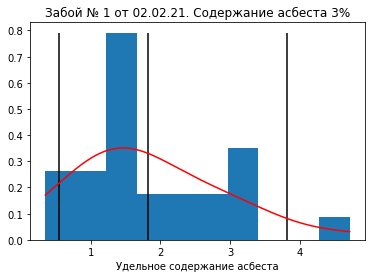

In [9]:
_, q50, _ = plot_dist_pz(res_020221_1, h)
q50s['02-02-21'][1] = q50
print('Среднее: ', np.mean(res_020221_1))
plt.title('Забой № 1 от 02.02.21. Содержание асбеста 3%')
plt.savefig('graphics/pit_1_020221.png',bbox_inches='tight', pad_inches=0)

## Забой № 2 от 02.02.21. Содержание 1.3-1.5%

In [10]:
res_020221_2 = calculate_info(data['02-02-21'][2]['images'], model_asbest)

In [11]:
h = get_h(res_020221_2)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


0.5134699999999599


Квантиль на уровне доверительной вероятности 0.05 =  0.35175991099764836
Квантиль на уровне доверительной вероятности 0.50 =  1.144321237414164
Квантиль на уровне доверительной вероятности 0.95 =  1.817572256628193
Среднее:  1.1721575701678242


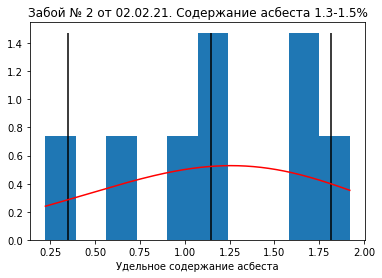

In [12]:
_, q50, _ = plot_dist_pz(res_020221_2, h)
q50s['02-02-21'][2] = q50
print('Среднее: ', np.mean(res_020221_2))
plt.title('Забой № 2 от 02.02.21. Содержание асбеста 1.3-1.5%')
plt.savefig('graphics/pit_2_020221.png',bbox_inches='tight', pad_inches=0)

## Забой № 1 от 16.12.20. Содержание 2%

In [13]:
res_161220_1 = calculate_info(data['16-12-20'][1]['images'], model_asbest)

In [14]:
h = get_h(res_161220_1)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


0.24774999999998898


Квантиль на уровне доверительной вероятности 0.05 =  1.1098703961491
Квантиль на уровне доверительной вероятности 0.50 =  1.4987373079893584
Квантиль на уровне доверительной вероятности 0.95 =  1.815748377424352
Среднее:  1.513283341019242


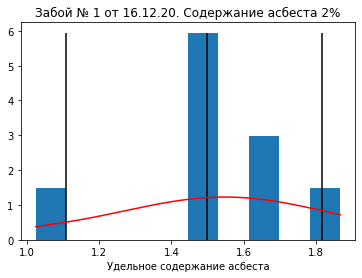

In [15]:
_, q50, _ = plot_dist_pz(res_161220_1, h)
q50s['16-12-20'][1] = q50
print('Среднее: ', np.mean(res_161220_1))
plt.title('Забой № 1 от 16.12.20. Содержание асбеста 2%')
plt.savefig('graphics/pit_1_161220.png',bbox_inches='tight', pad_inches=0)

## Забой № 2 от 16.12.20. Содержание 1.8-2%

In [16]:
res_161220_2 = calculate_info(data['16-12-20'][2]['images'], model_asbest)

In [17]:
h = get_h(res_161220_2)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


0.956399999999911


Квантиль на уровне доверительной вероятности 0.05 =  1.6989241197184806
Квантиль на уровне доверительной вероятности 0.50 =  2.976302584670556
Квантиль на уровне доверительной вероятности 0.95 =  4.656142757758216
Среднее:  2.8381215790171685


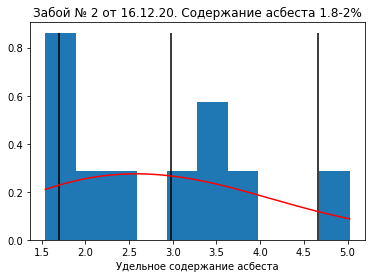

In [18]:
_, q50, _ = plot_dist_pz(res_161220_2, h)
q50s['16-12-20'][2] = q50
print('Среднее: ', np.mean(res_161220_2))
plt.title('Забой № 2 от 16.12.20. Содержание асбеста 1.8-2%')
plt.savefig('graphics/pit_2_161220.png',bbox_inches='tight', pad_inches=0)

## Забой № 3 от 16.12.20. Содержание 1.8-2%

In [19]:
res_161220_3 = calculate_info(data['16-12-20'][3]['images'], model_asbest)

In [20]:
h = get_h(res_161220_3)
print(h)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


1.4590599999998555


Квантиль на уровне доверительной вероятности 0.05 =  1.9632668551088777
Квантиль на уровне доверительной вероятности 0.50 =  3.6483309317614308
Квантиль на уровне доверительной вероятности 0.95 =  5.100354231855652
Среднее:  3.7778388129340277


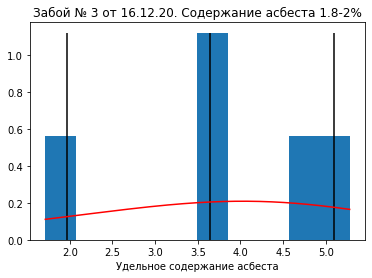

In [21]:
_, q50, _ = plot_dist_pz(res_161220_3, h)
q50s['16-12-20'][3] = q50
print('Среднее: ', np.mean(res_161220_3))
plt.title('Забой № 3 от 16.12.20. Содержание асбеста 1.8-2%')
plt.savefig('graphics/pit_3_161220.png',bbox_inches='tight', pad_inches=0)

## Забой № 4 от 16.12.20. Содержание 4%

In [22]:
res_161220_4 = calculate_info(data['16-12-20'][4]['images'], model_asbest)

In [23]:
h = get_h(res_161220_4)
print(h)

0.7411899999999347


Квантиль на уровне доверительной вероятности 0.05 =  1.618743958962201
Квантиль на уровне доверительной вероятности 0.50 =  3.0439651236506604
Квантиль на уровне доверительной вероятности 0.95 =  4.265583264812197
Среднее:  3.052340221012571


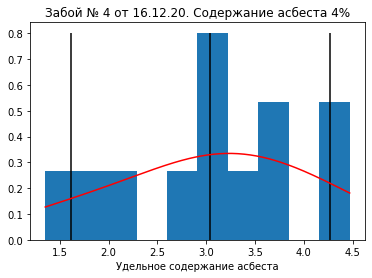

In [24]:
_, q50, _ = plot_dist_pz(res_161220_4, h)
q50s['16-12-20'][4] = q50
print('Среднее: ', np.mean(res_161220_4))
plt.title('Забой № 4 от 16.12.20. Содержание асбеста 4%')
plt.savefig('graphics/pit_4_161220.png',bbox_inches='tight', pad_inches=0)

 ## График зависимостей

In [53]:
q50s

{'02-02-21': {1: 0.01818567358003123, 2: 0.01129634877767018},
 '16-12-20': {1: 0.01521944317822717,
  2: 0.03026978254717598,
  3: 0.03707006982097748,
  4: 0.031013333048282986}}

[1.2462118  0.00266083]


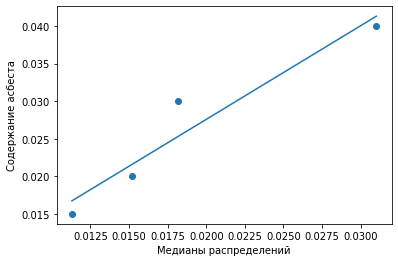

In [54]:
content = []
lst_50 = []
for date in q50s.keys():
    for pit in q50s[date].keys():
        if date == '16-12-20' and (pit == 2 or pit == 3):
            continue
        lst_50.append(q50s[date][pit])
        content.append(data[date][pit]['content'])

t = [min(lst_50), max(lst_50)]
p = np.polyfit(lst_50, content, 1)
y = np.polyval(p, t)
print(p)
        
        
plt.scatter(lst_50, content)
plt.plot(t, y)

plt.xlabel('Медианы распределений')
plt.ylabel('Содержание асбеста')
plt.savefig('graphics/content_asbest.png', bbox_inches='tight', pad_inches=0)